# PART 1 : To build a face identification model to recognize human faces.

In [1]:
#Importing all the necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2
import pixellib 
from pixellib.instance import instance_segmentation

import warnings
warnings.filterwarnings("ignore") # To ignore any warnings


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)

Tensorflow Version:  2.5.0


In [2]:
# Testing to check if available GPU is being used

if tf.test.is_gpu_available():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TensorFlow")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Default GPU Device: /device:GPU:0


In [3]:
# Changing the current working directory and declaring the paths.

project_path = r"E:\Python\Residency 10\ACV Projects\Project 2"
data_path = r"E:\Python\Residency 10\ACV Projects\Project 2\ACV Project 2 Dataset\PINS"
wpath = r"E:\Python\Residency 10\ACV Projects\Project 2\ACV Project 2 Dataset"
os.chdir(data_path)
os.getcwd()

'E:\\Python\\Residency 10\\ACV Projects\\Project 2\\ACV Project 2 Dataset\\PINS'

In [4]:
# Declaring variables

IMAGE_SIZE = 224
X = []
y = []

## 1. Load the dataset and create the metadata.

In [5]:
metadata = []
word = ['face','Face'] 

for i in os.listdir(data_path):
    fpath = os.path.join(data_path, i)
    temp = i.split("_")[-1] # To remove "pins_" from labels
    wordlist = temp.split()
    lbl = [x for x in wordlist if x not in word] #For removing unnecessary words like 'face' from labels
    lbl = ' '.join(lbl)
    for j in os.listdir(fpath):
        ipath = os.path.join(fpath, j)
        ext = os.path.splitext(j)[1]
        if ext == '.jpg' or ext == '.jpeg':
            metadata.append(ipath)
            img = cv2.imread(ipath, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            X.append(img)
            y.append(lbl)
        else:
            pass
      
metadata = np.array(metadata)
X = np.array(X)
y = np.array(y)

In [6]:
# Printing the shape of data 

print("Metadata shape:", metadata.shape)
print("Feature shape:", X.shape)
print("Label shape:", y.shape)

Metadata shape: (10770,)
Feature shape: (10770, 224, 224, 3)
Label shape: (10770,)


## 2.Check some samples of metadata.

In [7]:
metadata[100]

'E:\\Python\\Residency 10\\ACV Projects\\Project 2\\ACV Project 2 Dataset\\PINS\\pins_alexandra daddario\\alexandra daddario110.jpg'

In [8]:
X[100]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [9]:
y[100]

'alexandra daddario'

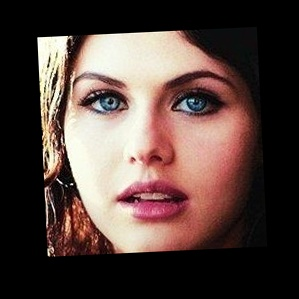

In [10]:
Image.open(metadata[100])

## 3. Load the pre-trained model and weights.

In [11]:
#Declaring the architecture of predefined model for VGG face

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [12]:
model = vgg_face()

model.load_weights(os.path.join(wpath, "vgg_face_weights.h5")) #Loading the weights for VGG Face.

In [13]:
model.layers[0], model.layers[-2]

(<tensorflow.python.keras.layers.convolutional.ZeroPadding2D at 0x14489f1d9a0>,
 <tensorflow.python.keras.layers.core.Flatten at 0x14511096f40>)

In [14]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output) #Instantiation of the model

In [15]:
type(vgg_face_descriptor)

tensorflow.python.keras.engine.functional.Functional

In [16]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<tf.Tensor 'zero_padding2d_input:0' shape=(None, 224, 224, 3) dtype=float32>],
 [<tf.Tensor 'flatten/Reshape:0' shape=(None, 2622) dtype=float32>])

## 4. Generate Embedding vectors for each face in the dataset.

In [17]:
X = (X/255.).astype(np.float32) #Normalizing features

In [18]:
X = X.reshape(X.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3) #Reshaping features

In [19]:
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(X[100], axis=0))[0]
print("Embedding vector Shape: ", embedding_vector.shape)

Embedding vector Shape:  (2622,)


In [20]:
embedding_vector[0], type(embedding_vector), type(embedding_vector[0])

(0.017108621, numpy.ndarray, numpy.float32)

In [21]:
embedding_vector[5], embedding_vector[102], embedding_vector[-2]

(0.009495933, -0.028364778, 0.022181274)

In [22]:
total_images = len(metadata)

print('Total images :', total_images)

Total images : 10770


In [23]:
embeddings = np.zeros((metadata.shape[0], embedding_vector.shape[0]))
for i in range(0, total_images):
    img = X[i]
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

In [24]:
print("Embedding vector Shape: ", embeddings.shape)

Embedding vector Shape:  (10770, 2622)


## 5. Build distance metrics for identifying the distance between two given images.

In [25]:
#Function to calculate distance between given 2 pairs of images
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [26]:
#Plotting images and get distance between the pairs
def show_pair(img1, img2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {img1} & {img2}= {distance(embeddings[img1], embeddings[img2]):.2f}')
    plt.subplot(121)
    plt.imshow(X[img1])
    plt.subplot(122)
    plt.imshow(X[img2])  

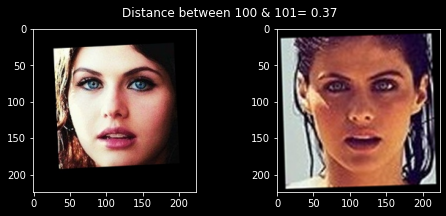

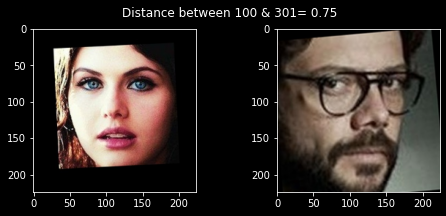

In [27]:
show_pair(100, 101)
show_pair(100, 301)

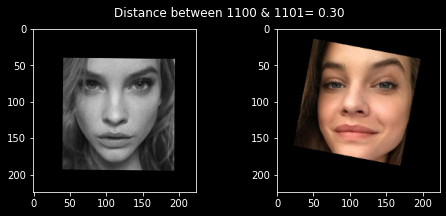

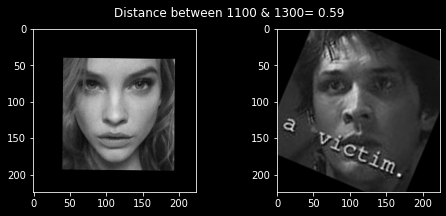

In [28]:
show_pair(1100, 1101)
show_pair(1100, 1300)

In [29]:
#Splitting the data into training and testing

X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, shuffle = True, random_state = 42, stratify = y)

In [30]:
print('Dimesions of training data : ', X_train.shape)
print('Dimesions of training label : ', y_train.shape)
print()
print('Dimesions of testing data : ', X_test.shape)
print('Dimesions of testing label : ', y_test.shape)
print()
print("Unique labels in train is '{0}' and test '{1}' ".format(len(np.unique(y_test)), len(np.unique(y_train))))

Dimesions of training data :  (8616, 2622)
Dimesions of training label :  (8616,)

Dimesions of testing data :  (2154, 2622)
Dimesions of testing label :  (2154,)

Unique labels in train is '99' and test '99' 


In [31]:
y_test[0], y_train[988]

('brie larson', 'bellamy blake')

In [32]:
#Encoding the Labels

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [33]:
print(le.classes_)

['' 'Aaron Paul' 'Alvaro Morte' 'Amanda Crew' 'Amaury Nolasco' 'Anna Gunn'
 'Benedict Cumberbatch' 'Betsy Brandt' 'Brenton Thwaites' 'Brit Marling'
 'Bryan Cranston' 'Caity Lotz' 'Cameron Monaghan' 'Chance Perdomo'
 'Chris Evans' 'Chris Pratt' 'Cobie Smulders' 'Danielle Panabaker'
 'Dave Franco' 'Dominic Purcell' 'Dwayne Johnson' 'Emilia Clarke'
 'Emily Bett Rickards' 'Emma Stone' 'Gwyneth Paltrow' 'Henry Cavil'
 'Jason Momoa' 'Jeremy Renner' 'Jesse Eisenberg' 'Jim Parsons'
 'Jon Bernthal' 'Josh Radnor' 'Kit Harington' 'Krysten Ritter'
 'Kumail Nanjiani' 'Maisie Williams' 'Mark Ruffalo' 'Martin Starr'
 'Melissa benoit' 'Mike Colter' 'Morena Baccarin' 'Morgan Freeman'
 'Neil Patrick Harris' 'Paul Rudd' 'Pedro Alonso' 'Peter Dinklage'
 'RJ Mitte' 'Rami Melek' 'Robert Knepper' 'Robin Taylor' 'Ryan Reynolds'
 'Sarah Wayne Callies' 'Scarlett Johansson' 'Sebastian Stan'
 'Sophie Turner' 'Stephen Amell' 'Sundar Pichai' 'Thomas Middleditch'
 'Tom Cavanagh' 'Ursula Corbero' 'Wentworth Miller' '

In [34]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [ 2 37  8 ... 96 47 50]
y_test_encoded :  [70 38 35 ... 95 38 44]


In [35]:
#Standardizing the feature values using StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [36]:
print('X_train_std shape : ', X_train_std.shape)
print('y_train_encoded shape : ', y_train_encoded.shape)
print()
print('X_test_std shape : ', X_test_std.shape)
print('y_test_encoded shape : ', y_test_encoded.shape)

X_train_std shape :  (8616, 2622)
y_train_encoded shape :  (8616,)

X_test_std shape :  (2154, 2622)
y_test_encoded shape :  (2154,)


## 6. Use PCA for dimensionality reduction.

In [37]:
#Reducing feature dimensions using Principal Component Analysis

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

## 7. Build an SVM classifier to map each image to its right person.

In [38]:
#Building a SVM Classifier to predict the person in the given image

clf = SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.001)

## 8. Predict using the SVM model.

In [39]:
y_pred = clf.predict(X_test_pca)

In [40]:
y_pred_encoded = le.inverse_transform(y_pred)

In [41]:
# Find the classification accuracy
accuracy_score(y_test_encoded, y_pred)

0.9433611884865367

In [42]:
# Classification Report
print("Classification Report:\n", classification_report(y_test_encoded, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.98      0.69        57
           1       1.00      0.94      0.97        17
           2       1.00      0.94      0.97        18
           3       1.00      0.96      0.98        24
           4       1.00      0.96      0.98        23
           5       1.00      0.92      0.96        13
           6       0.93      0.81      0.87        16
           7       1.00      0.93      0.96        14
           8       0.92      0.92      0.92        26
           9       1.00      0.92      0.96        24
          10       0.94      0.94      0.94        16
          11       0.96      0.88      0.92        25
          12       0.96      1.00      0.98        22
          13       1.00      1.00      1.00        17
          14       0.84      0.89      0.86        18
          15       0.93      0.96      0.95        28
          16       1.00      1.00      1.00        26
   

### Inferences:- '0' label is the only one with low F1 score of 69% rest all labels are having F1 score of 85% or above.

## Overall Inferences for PART 1:-
### 1.This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library.
### 2.Embeddings for all images are generated using pre-trained VGG Face model.
### 3.The distance between given 2 pairs of images is calculated using "Squared L2 distance".
### 4.Encoded the target variables, standardize the features and reduced dimensions using PCA to 128 components.
### 5.SVM classifier was used to predict the face in a given image and achieved a 94.336% accuracy.

# PART 2 : To understand the traffic density on road during busy hours in order to efficiently program their traffic lights.

## Creating an automation using computer vision to impute dynamic bounding boxes to locate cars or vehicles on the road by using the pre-trained mask RCNN on COCO Dataset.

In [43]:
#Changing the directory 

os.chdir(wpath)
os.getcwd()

'E:\\Python\\Residency 10\\ACV Projects\\Project 2\\ACV Project 2 Dataset'

### Link to Mask RCNN coco model weights :-
#### https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [44]:
# Instantiation the instance_segmentation along with loading the Mask RCNN coco weights for prediction.

segment_video = instance_segmentation()
segment_video.load_model("mask_rcnn_coco.h5") #Downloaded the Mask RCNN coco weights externally
target_classes = segment_video.select_target_classes(car=True, bicycle=True, truck=True, motorcycle=True, bus=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead


In [45]:
#Dynamic Bounding Box prediction on video1 using pretrained mask RCNN weights.
segment_video.process_video("video1.mp4", show_bboxes = True, segment_target_classes= target_classes, frames_per_second= 15, output_video_name="traffic_monitor_video1.mp4")

No. of frames: 1
No. of frames: 2
No. of frames: 3
No. of frames: 4
No. of frames: 5
No. of frames: 6
No. of frames: 7
No. of frames: 8
No. of frames: 9
No. of frames: 10
No. of frames: 11
No. of frames: 12
No. of frames: 13
No. of frames: 14
No. of frames: 15
No. of frames: 16
No. of frames: 17
No. of frames: 18
No. of frames: 19
No. of frames: 20
No. of frames: 21
No. of frames: 22
No. of frames: 23
No. of frames: 24
No. of frames: 25
No. of frames: 26
No. of frames: 27
No. of frames: 28
No. of frames: 29
No. of frames: 30
No. of frames: 31
No. of frames: 32
No. of frames: 33
No. of frames: 34
No. of frames: 35
No. of frames: 36
No. of frames: 37
No. of frames: 38
No. of frames: 39
No. of frames: 40
No. of frames: 41
No. of frames: 42
No. of frames: 43
No. of frames: 44
No. of frames: 45
No. of frames: 46
No. of frames: 47
No. of frames: 48
No. of frames: 49
No. of frames: 50
No. of frames: 51
No. of frames: 52
No. of frames: 53
No. of frames: 54
No. of frames: 55
No. of frames: 56
N

({'rois': array([[192,  34, 219,  73],
         [248, 206, 291, 260],
         [217, 160, 252, 205],
         [192, 135, 216, 173],
         [260, 482, 306, 538],
         [183, 201, 209, 238],
         [159, 222, 182, 248],
         [145, 275, 164, 302],
         [141, 489, 157, 510],
         [165, 259, 188, 286],
         [222, 432, 263, 477],
         [132, 255, 147, 273],
         [190, 255, 217, 287],
         [164,  94, 185, 125],
         [185, 422, 215, 460],
         [123, 422, 134, 440],
         [131, 223, 147, 241],
         [104, 340, 113, 352],
         [118, 368, 131, 387],
         [125, 288, 141, 304],
         [137, 112, 155, 132],
         [119, 140, 133, 163]]),
  'class_ids': array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
  'scores': array([0.99519145, 0.9905405 , 0.98756903, 0.9789354 , 0.9768623 ,
         0.9735618 , 0.9734808 , 0.9727065 , 0.97233677, 0.9701909 ,
         0.9647077 , 0.96359795, 0.96007323, 0.9420584 , 0.9122046 ,
 

In [46]:
#Dynamic Bounding Box prediction on video2 using pretrained mask RCNN weights.
segment_video.process_video("video2.mp4", show_bboxes = True, segment_target_classes= target_classes, frames_per_second= 15, output_video_name="traffic_monitor_video2.mp4")

No. of frames: 1
No. of frames: 2
No. of frames: 3
No. of frames: 4
No. of frames: 5
No. of frames: 6
No. of frames: 7
No. of frames: 8
No. of frames: 9
No. of frames: 10
No. of frames: 11
No. of frames: 12
No. of frames: 13
No. of frames: 14
No. of frames: 15
No. of frames: 16
No. of frames: 17
No. of frames: 18
No. of frames: 19
No. of frames: 20
No. of frames: 21
No. of frames: 22
No. of frames: 23
No. of frames: 24
No. of frames: 25
No. of frames: 26
No. of frames: 27
No. of frames: 28
No. of frames: 29
No. of frames: 30
No. of frames: 31
No. of frames: 32
No. of frames: 33
No. of frames: 34
No. of frames: 35
No. of frames: 36
No. of frames: 37
No. of frames: 38
No. of frames: 39
No. of frames: 40
No. of frames: 41
No. of frames: 42
No. of frames: 43
No. of frames: 44
No. of frames: 45
No. of frames: 46
No. of frames: 47
No. of frames: 48
No. of frames: 49
No. of frames: 50
No. of frames: 51
No. of frames: 52
No. of frames: 53
No. of frames: 54
No. of frames: 55
No. of frames: 56
N

({'rois': array([], dtype=float64),
  'class_ids': array([], dtype=float64),
  'scores': array([], dtype=float64),
  'masks': array([], dtype=float64)},
 array([[[8, 8, 8],
         [8, 8, 8],
         [8, 8, 8],
         ...,
         [8, 8, 8],
         [8, 8, 8],
         [8, 8, 8]],
 
        [[8, 8, 8],
         [8, 8, 8],
         [8, 8, 8],
         ...,
         [8, 8, 8],
         [8, 8, 8],
         [8, 8, 8]],
 
        [[8, 8, 8],
         [8, 8, 8],
         [8, 8, 8],
         ...,
         [8, 8, 8],
         [8, 8, 8],
         [8, 8, 8]],
 
        ...,
 
        [[8, 8, 8],
         [8, 8, 8],
         [8, 8, 8],
         ...,
         [8, 8, 8],
         [8, 8, 8],
         [8, 8, 8]],
 
        [[8, 8, 8],
         [8, 8, 8],
         [8, 8, 8],
         ...,
         [8, 8, 8],
         [8, 8, 8],
         [8, 8, 8]],
 
        [[8, 8, 8],
         [8, 8, 8],
         [8, 8, 8],
         ...,
         [8, 8, 8],
         [8, 8, 8],
         [8, 8, 8]]], dtype=uint8

## Overall Inferences for PART 2:-
### 1.For automating to impute dynamic bounding box over a video to locate cars or vehicles on the road can be solved by using pixellib library with the mask rcnn weights trained on coco dataset.
### 2.Target classes can be specifically mentioned to limit the predictions to vehicles only.